<a href="https://colab.research.google.com/github/michaeledge27/CSCI290/blob/main/notebooks/kMeansClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [35]:
iris = load_iris()

In [36]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [37]:
df["species"] = iris.target

In [38]:
target_names = {
    0: "setosa",
    1: "versicolor",
    2: "virginica"
}

df["species_name"] = df["species"].map(target_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


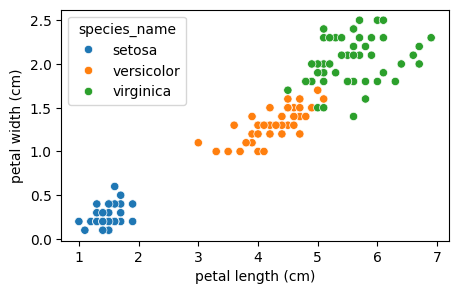

In [39]:
plt.figure(figsize=(5, 3))
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "species_name");

In [40]:
df[['current_cluster']] = -1
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name,current_cluster
0,5.1,3.5,1.4,0.2,0,setosa,-1
1,4.9,3.0,1.4,0.2,0,setosa,-1
2,4.7,3.2,1.3,0.2,0,setosa,-1
3,4.6,3.1,1.5,0.2,0,setosa,-1
4,5.0,3.6,1.4,0.2,0,setosa,-1
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica,-1
146,6.3,2.5,5.0,1.9,2,virginica,-1
147,6.5,3.0,5.2,2.0,2,virginica,-1
148,6.2,3.4,5.4,2.3,2,virginica,-1


# k-Means Algorithm

In [41]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

In [42]:
# return random sample of k initial centroids
def get_random_centroids(df, k):
    return df.sample(k).drop(columns=["species", "species_name"])

In [43]:
get_random_centroids(df, 3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
25,5.0,3.0,1.6,0.2,-1
109,7.2,3.6,6.1,2.5,-1
88,5.6,3.0,4.1,1.3,-1


In [44]:
get_random_centroids(df, 3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
50,7.0,3.2,4.7,1.4,-1
149,5.9,3.0,5.1,1.8,-1
133,6.3,2.8,5.1,1.5,-1


In [45]:
# compare old centroids to new centroids to see if the algorithm has converged yet
# return true if new_centroids is equal to old_centroids, false otherwise
def check_new_centroids(old_centroids, new_centroids):
    return True if euclidean_distance(old_centroids, new_centroids).all() <= 0.001 else False

In [46]:
def update_centroids(df, centroids):
    return df.groupby("current_cluster")[[df.columns]].mean()


In [47]:
def get_cluster(df, centroids):
    # initialize old centroids as an empty dataframe
    old_centroids = pd.DataFrame()
    # initialize dict to hold cluster assignments
    cluster_assignments = {}
    # run iteratively while the new centroids are different from the old ones
    while not check_new_centroids(old_centroids, centroids):
        # update the old centroids
        old_centroids = centroids.copy()
        # iterate over each point in the data frame
        for i in df.index:
            # store distances from current point to each centroid
            distances = []
            # iterate over each centroid
            for j in centroids.index:
                # calculate euclidean distance from current point to current centroid
                distances.append(euclidean_distance(df.loc[i], centroids.loc[j]))
            # get the index of the cluster the point is closest to
            # assign the point to the cluster with the closest centroid
            df.loc[i, 'current_cluster'] = np.argmin(distances)
        centroids = update_centroids(df, centroids)



In [48]:
get_cluster(df, get_random_centroids(df, 3))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [49]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name,current_cluster
0,5.1,3.5,1.4,0.2,0,setosa,-1
1,4.9,3.0,1.4,0.2,0,setosa,-1
2,4.7,3.2,1.3,0.2,0,setosa,-1
3,4.6,3.1,1.5,0.2,0,setosa,-1
4,5.0,3.6,1.4,0.2,0,setosa,-1
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica,-1
146,6.3,2.5,5.0,1.9,2,virginica,-1
147,6.5,3.0,5.2,2.0,2,virginica,-1
148,6.2,3.4,5.4,2.3,2,virginica,-1
